- Original code from Y. Chen

- Modified by Jae Hoon (Daniel) Lee

In [ ]:
import torch
import numpy as np
import scipy.integrate
solver = scipy.integrate.solve_ivp
from numpy import sin, cos 
import matplotlib.pyplot as plt
import random

seed = 36
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True

In [ ]:
#parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

def func(t, state):
  cosv = np.cos(state[0]-state[1])
  sinv = np.sin(state[0]-state[1])
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (
              g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) 
            - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv
            ) / (l1*(m/m2-cosv*cosv))
  dvdt[3] = (
              g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) 
            + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)
            ) / (l2*(m/m2-cosv*cosv))
  return dvdt

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]
num = 2000
x1_init = np.random.randn(num)
x2_init = np.random.randn(num)
v1_init = np.random.randn(num)
v2_init = np.random.randn(num)
state = np.random.randn(num, 4)

# In order to have the numbers in (q1, q2, v1, v2) order be 
# the SAME as those in (q1, v1, q2, v2) order used in the original code of Y. Chen,
# we do not touch random number generation, but need to swap 1 and 2.
temp = state[:, 1]
state[:, 1] = state[:, 2]
state[:, 2] = temp

flag = False
for i in range(num):
  sol = solver(func, [0, tend], state[i], t_eval=t_eval)
  tval = sol['t']
  q1 = sol['y'][0]
  q2 = sol['y'][1]
  v1 = sol['y'][2]
  v2 = sol['y'][3]
  xval = np.vstack([q1, q2, v1, v2])
  dxdt = func(tval, xval)
  if flag:
    x_input = np.concatenate([x_input, xval], 1)
    x_target = np.concatenate([x_target, dxdt], 1)
  else:
    x_input = xval
    x_target = dxdt
    flag = True

# Data normalization:
# Unlike Y. Chen, I scale input and target by their max_abs, respectively.
x_input_max = np.abs(x_input).max(axis=1)
x_target_max = np.abs(x_target).max(axis=1)
A = np.diag(x_target_max)
B = np.diag(x_input_max) # Now B differs from A.

x_input = np.matmul(np.linalg.inv(B),x_input)
x_target = np.linalg.inv(A)@x_target

In [3]:
print('x_input shape:', x_input.shape)
print('x_target shape:', x_target.shape)

x_input shape: (4, 200000)
x_target shape: (4, 200000)


In [4]:
target_file = np.savetxt("target_dp_sep_sc.csv", x_target.T, delimiter=',')
input_file = np.savetxt("input_dp_sep_sc.csv", x_input.T, delimiter=',')

In [5]:
A_file = np.savetxt("A_dp_sep_sc.csv", A, delimiter=',')
B_file = np.savetxt("B_dp_sep_sc.csv", B, delimiter=',')

Check Data

In [6]:
import numpy as np
import pandas as pd
A = pd.read_csv("./A_dp_sep_sc.csv", header=None, dtype=np.float32)
B = pd.read_csv("./B_dp_sep_sc.csv", header=None, dtype=np.float32)
A = np.asmatrix(A)
B = np.asmatrix(B)
x_input_scaled = pd.read_csv("./input_dp_sep_sc.csv", header=None, dtype=np.float32)
x_target_scaled = pd.read_csv("./target_dp_sep_sc.csv", header=None, dtype=np.float32)
x_input_scaled = np.asmatrix(x_input_scaled)
x_target_scaled = np.asmatrix(x_target_scaled)

print('A matrix:\n', A)
print('B matrix:\n', B)
print('x_input_scaled shape:', x_input_scaled.shape)
print('x_target_scaled shape:', x_target_scaled.shape)

A matrix:
 [[ 14.132842   0.         0.         0.      ]
 [  0.        16.193363   0.         0.      ]
 [  0.         0.       179.0959     0.      ]
 [  0.         0.         0.       220.93365 ]]
B matrix:
 [[21.906992  0.        0.        0.      ]
 [ 0.       27.135761  0.        0.      ]
 [ 0.        0.       14.132842  0.      ]
 [ 0.        0.        0.       16.193363]]
x_input_scaled shape: (200000, 4)
x_target_scaled shape: (200000, 4)


x_input_original shape: (200000, 4)
x_target_original shape: (200000, 4)
Sample 0 / 2000 processed.


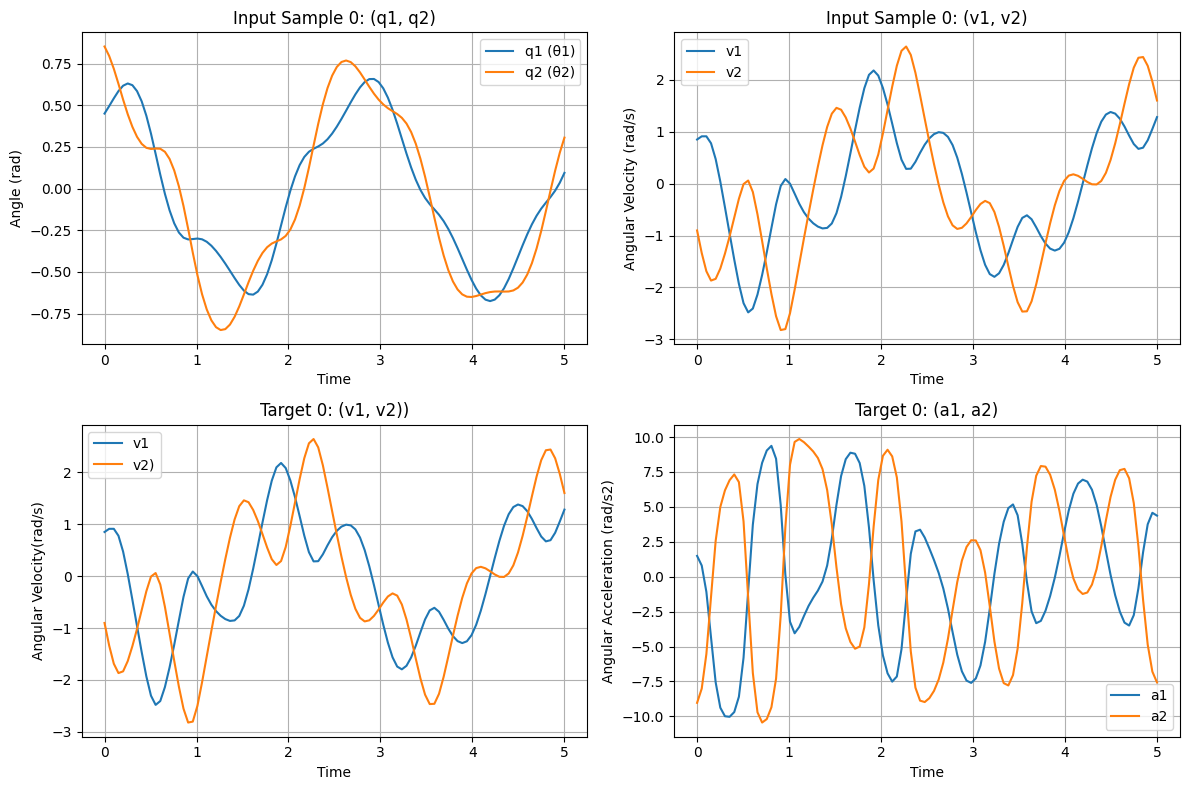

Sample 500 / 2000 processed.


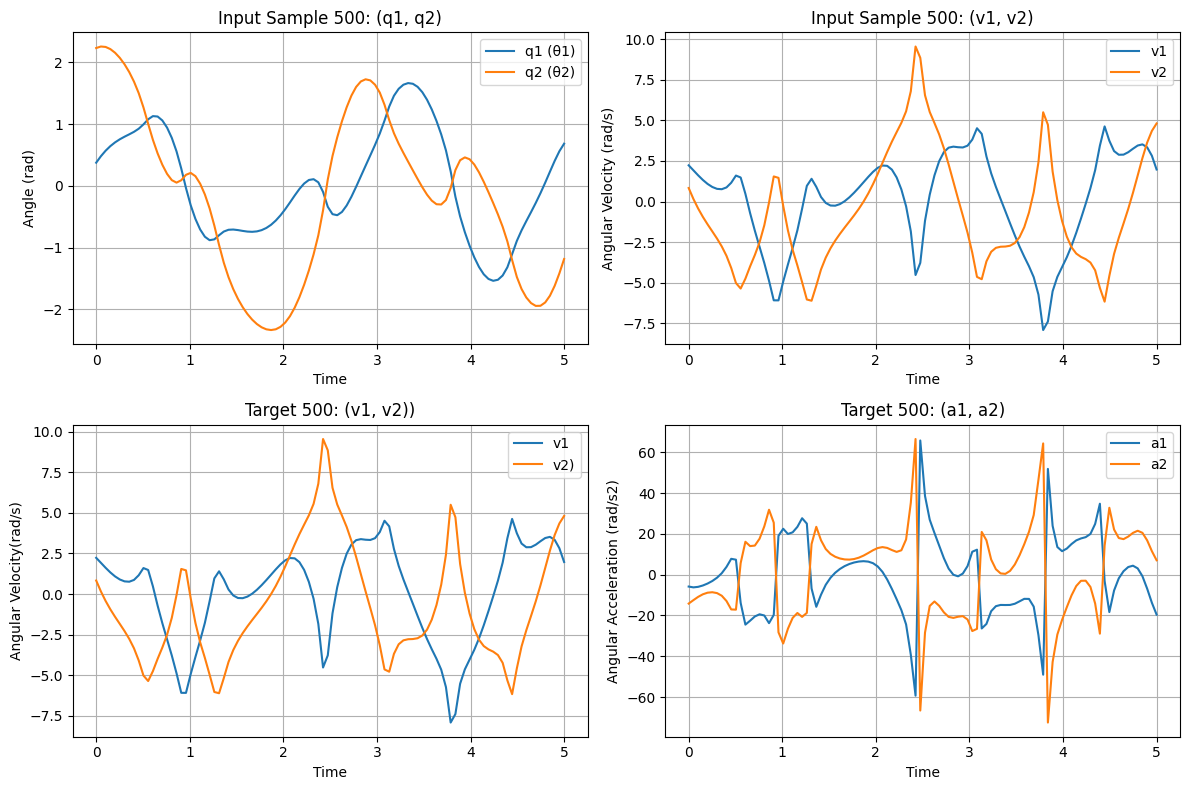

Sample 1000 / 2000 processed.


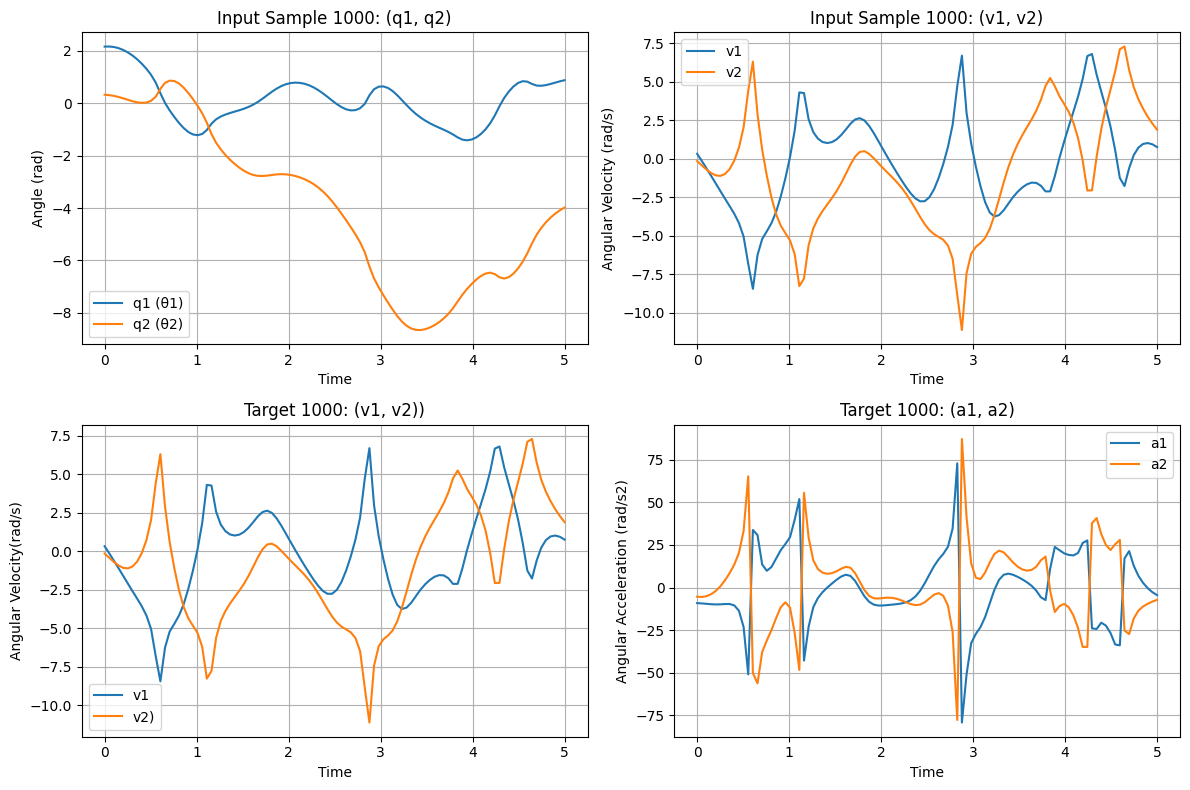

Sample 1500 / 2000 processed.


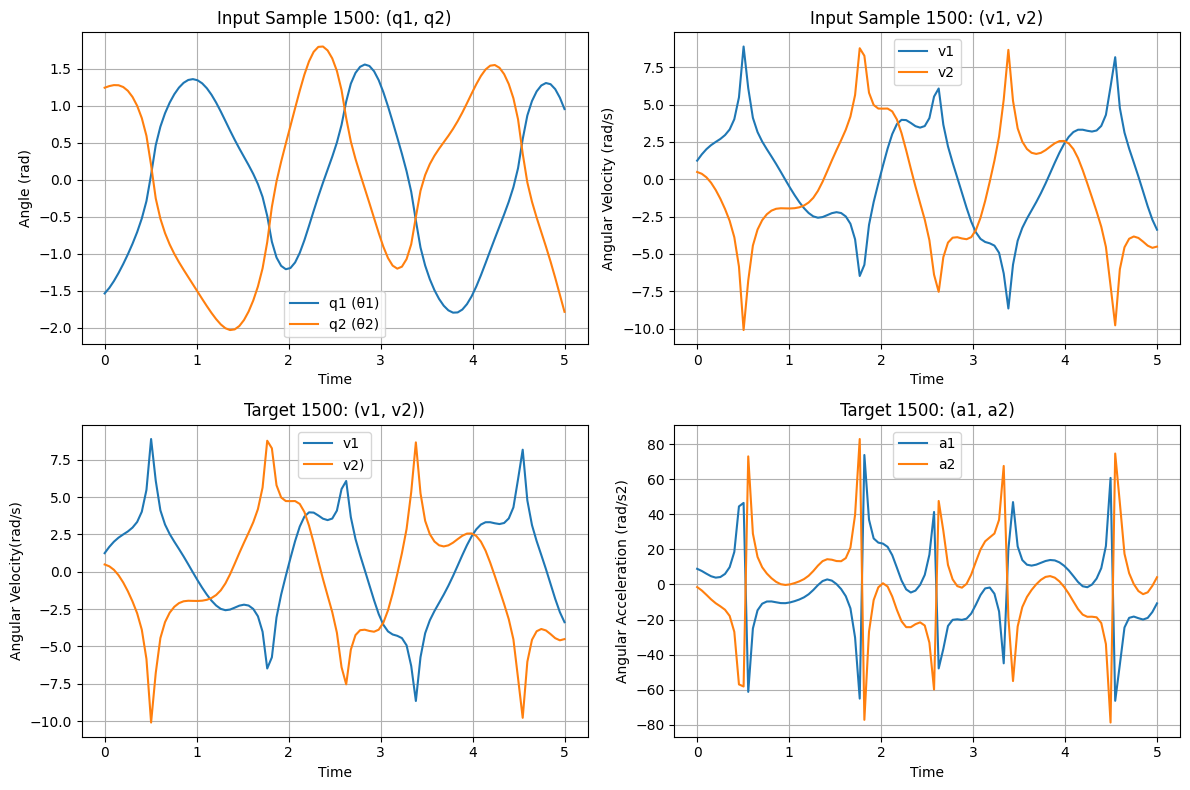

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]
num = 2000 # number of samples for initial state vectors
x_input_original = B @ x_input_scaled.T
x_input_original = x_input_original.T
x_target_original = A @ x_target_scaled.T # Now B differs from A.
x_target_original = x_target_original.T
print('x_input_original shape:', x_input_original.shape)
print('x_target_original shape:', x_target_original.shape)  

for i in range(num):
  if i % 500 == 0:
    print(f'Sample {i} / {num} processed.')

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.title(f'Input Sample {i}: (q1, q2)')
    plt.plot(t_eval, x_input_original[i*M:(i+1)*M, 0], label='q1 (θ1)')
    plt.plot(t_eval, x_input_original[i*M:(i+1)*M, 1], label='q2 (θ2)')
    plt.xlabel('Time')
    plt.ylabel('Angle (rad)')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title(f'Input Sample {i}: (v1, v2)')
    plt.plot(t_eval, x_input_original[i*M:(i+1)*M, 2], label='v1')
    plt.plot(t_eval, x_input_original[i*M:(i+1)*M, 3], label='v2')
    plt.xlabel('Time')
    plt.ylabel('Angular Velocity (rad/s)')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.title(f'Target {i}: (v1, v2))')
    plt.plot(t_eval, x_target_original[i*M:(i+1)*M, 0], label='v1')
    plt.plot(t_eval, x_target_original[i*M:(i+1)*M, 1], label='v2)')
    plt.xlabel('Time')
    plt.ylabel('Angular Velocity(rad/s)')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.title(f'Target {i}: (a1, a2)')
    plt.plot(t_eval, x_target_original[i*M:(i+1)*M, 2], label='a1')
    plt.plot(t_eval, x_target_original[i*M:(i+1)*M, 3], label='a2')
    plt.xlabel('Time')
    plt.ylabel('Angular Acceleration (rad/s2)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show() 

Sample 0 / 2000 processed.


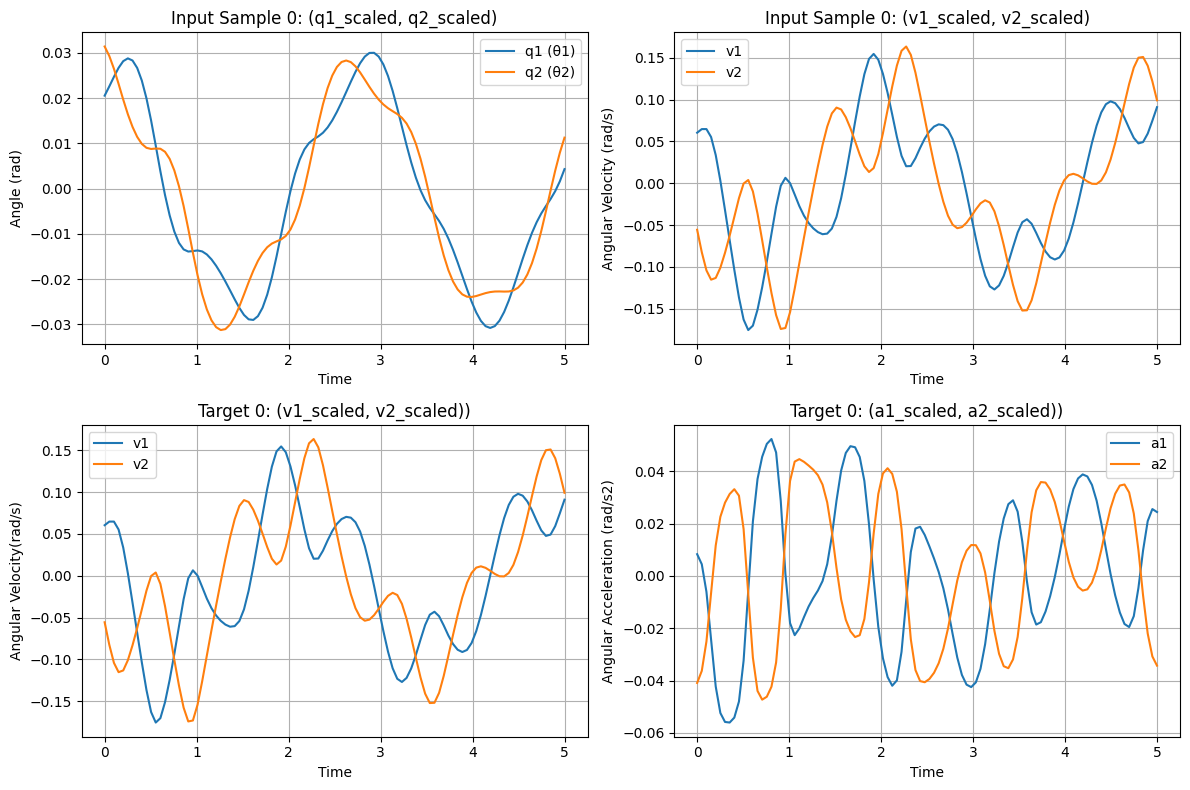

Sample 500 / 2000 processed.


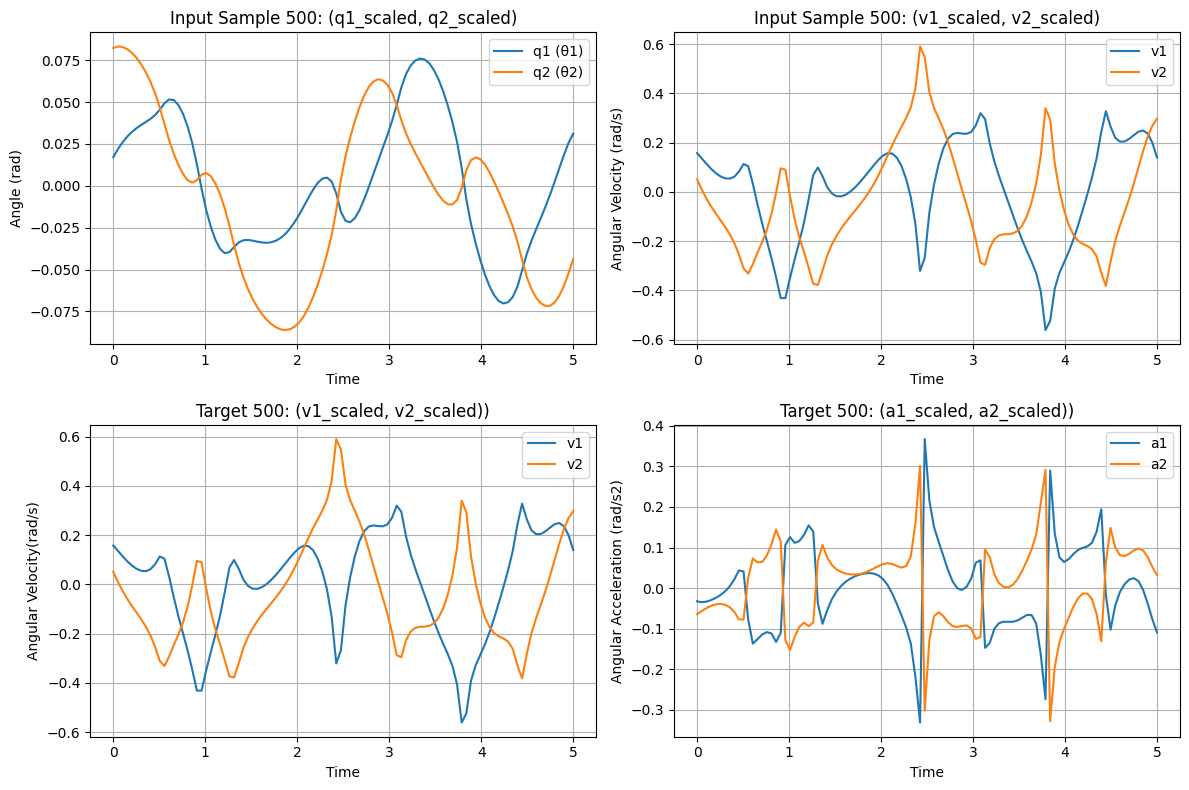

Sample 1000 / 2000 processed.


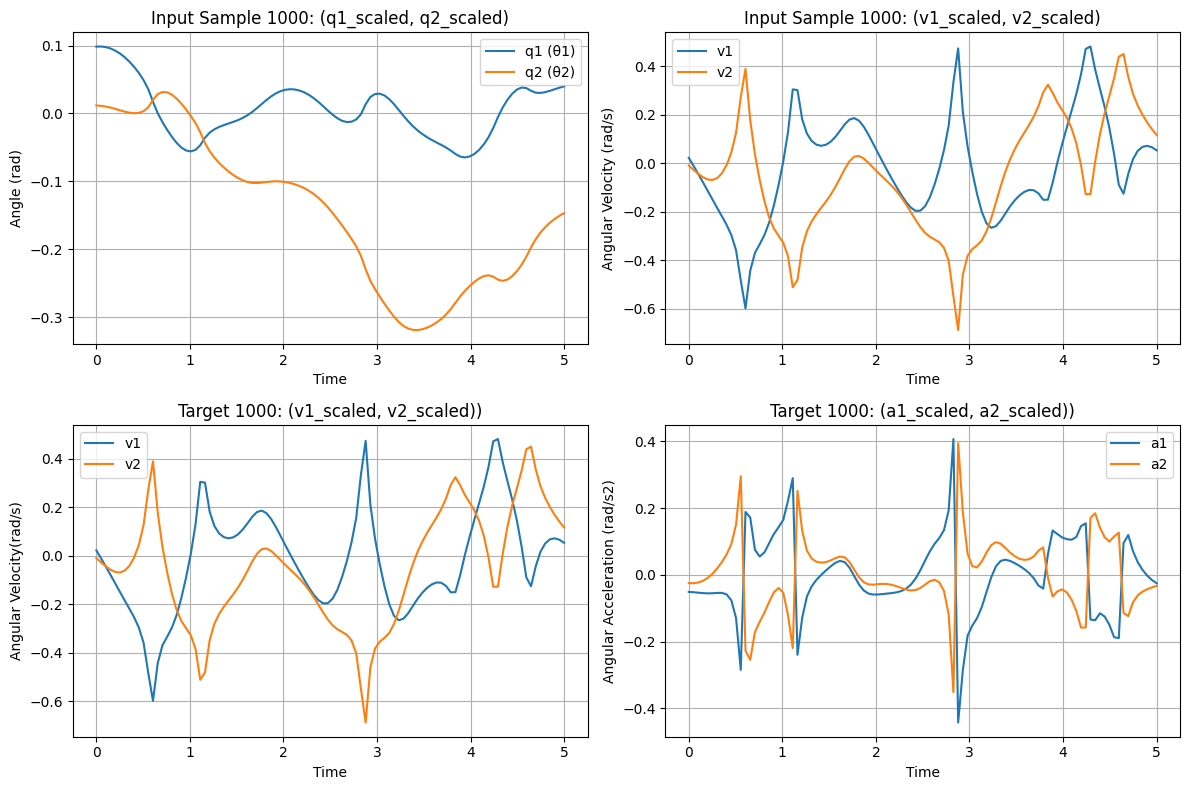

Sample 1500 / 2000 processed.


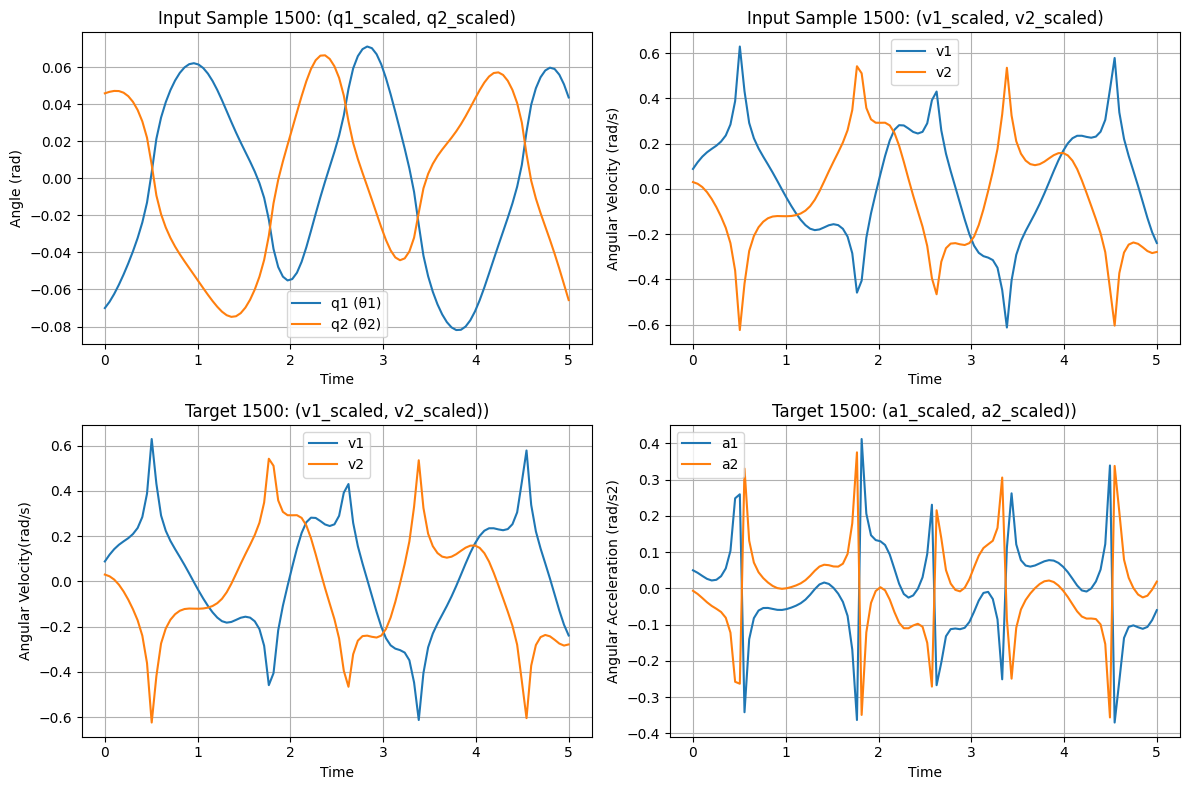

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]
num = 2000 # number of samples for initial state vectors
for i in range(num):
  if i % 500 == 0:
    print(f'Sample {i} / {num} processed.')

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.title(f'Input Sample {i}: (q1_scaled, q2_scaled)')
    plt.plot(t_eval, x_input_scaled[i*M:(i+1)*M, 0], label='q1 (θ1)')
    plt.plot(t_eval, x_input_scaled[i*M:(i+1)*M, 1], label='q2 (θ2)')
    plt.xlabel('Time')
    plt.ylabel('Angle (rad)')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title(f'Input Sample {i}: (v1_scaled, v2_scaled)')
    plt.plot(t_eval, x_input_scaled[i*M:(i+1)*M, 2], label='v1')
    plt.plot(t_eval, x_input_scaled[i*M:(i+1)*M, 3], label='v2')
    plt.xlabel('Time')
    plt.ylabel('Angular Velocity (rad/s)')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.title(f'Target {i}: (v1_scaled, v2_scaled))')
    plt.plot(t_eval, x_target_scaled[i*M:(i+1)*M, 0], label='v1')
    plt.plot(t_eval, x_target_scaled[i*M:(i+1)*M, 1], label='v2')
    plt.xlabel('Time')
    plt.ylabel('Angular Velocity(rad/s)')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.title(f'Target {i}: (a1_scaled, a2_scaled))')
    plt.plot(t_eval, x_target_scaled[i*M:(i+1)*M, 2], label='a1')
    plt.plot(t_eval, x_target_scaled[i*M:(i+1)*M, 3], label='a2')
    plt.xlabel('Time')
    plt.ylabel('Angular Acceleration (rad/s2)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show() 